# fig_rq3_tpch

Plot TPCH RQ3 results for scenario=RQ3_DEFAULT across scale factors.


In [1]:
# --- Bootstrap paths so imports work both inside/outside VS Code ---
import sys
from pathlib import Path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import math
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

from viz_results_toolkit import savefig_multi
from scripts.parse_tpch_results import (
    collect_tpch_rq3_results,
    collect_tpch_rq1_results,
    query_results_dataframe,
    display_query_scenarios,
)

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)


In [2]:
# --- Plotting constants and helper ---

LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]

LAYOUT_COLORS = {
    "no_layout": "#1f77b4",
    "linear": "#ff7f0e",
    "zorder": "#2ca02c",
    "hilbert": "#d62728",
}

SCALE_ORDER = [1, 4, 16, 64]
SCALE_DISPLAY = {1: "SF1", 4: "SF4", 16: "SF16", 64: "SF64"}
RQ3_DEFAULT_SCENARIO = "RQ3_DEFAULT"
RQ1_DEFAULT_SCENARIO = "SCENARIO_DEFAULT"

LAYOUT_HATCHES = {
    "no_layout": "////",
    "linear": "\\",
    "zorder": "xx",
    "hilbert": "..",
}

LAYOUT_MARKERS = {
    "no_layout": "o",
    "linear": "s",
    "zorder": "^",
    "hilbert": "D",
}

LAYOUT_LINESTYLES = {
    "no_layout": "-",
    "linear": "--",
    "zorder": "-.",
    "hilbert": ":",
}

BLOCK_GAP = 0.8
SCALE_RE = re.compile(r"scale=(\d+)")


def add_rq3_scale_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    scenario_names = df["scenario_name"].astype(str)
    df["scenario_base"] = scenario_names.str.split("_scale=", n=1).str[0]
    df["scale"] = pd.to_numeric(scenario_names.str.extract(SCALE_RE)[0], errors="coerce").astype("Int64")
    return df


def plot_scale_layout_boxes(df, metric, *, scale_order, layout_order, ax, title, scale_display=None, log_scale=False, log_zero_fill=1):
    scale_display = scale_display or {}
    cluster_centers = []
    cluster_labels = []
    block_spans = []
    color_handles = []
    seen_layouts = set()
    pos = 1
    for scale in scale_order:
        df_s = df[df["scale"] == scale]
        if df_s.empty:
            continue
        start = pos
        cluster_has_data = False
        for layout in layout_order:
            df_sl = df_s[df_s["layout"] == layout]
            vals = df_sl[metric].dropna().values
            if log_scale:
                vals = np.where(vals <= 0, log_zero_fill, vals)
            if vals.size == 0:
                continue
            cluster_has_data = True
            box = ax.boxplot(vals, positions=[pos], widths=0.7, patch_artist=True, showfliers=False)
            color = LAYOUT_COLORS.get(layout, "#888888")
            for patch in box['boxes']:
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            for element in ('caps', 'whiskers', 'medians'):
                for artist in box[element]:
                    artist.set_color(color)
            ax.plot(pos, vals.mean(), marker='o', color=color, markersize=4)
            if layout not in seen_layouts:
                color_handles.append(mpatches.Patch(color=color, label=layout))
                seen_layouts.add(layout)
            pos += 1
        if cluster_has_data:
            end = pos - 1
            cluster_centers.append((start + end) / 2)
            cluster_labels.append(scale_display.get(scale, f"SF{scale}"))
            block_spans.append((start, end))
            pos += BLOCK_GAP
    if cluster_centers:
        ax.set_xticks(cluster_centers)
        ax.set_xticklabels(cluster_labels, rotation=15, ha='right')
    ax.set_ylabel(metric)
    for (s, e) in block_spans[:-1]:
        ax.axvline(e + BLOCK_GAP / 2, linestyle='--', color='gray', alpha=0.3)
    ax.set_title(title, pad=16)
    if log_scale:
        ax.set_yscale('log')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    return color_handles


In [3]:
# --- Helper method to load+plot arbitrary query sets ---
def plot_rq3_tpch_queries(
    queries,
    *,
    scenario_base=RQ3_DEFAULT_SCENARIO,
    selectivity_filter=None,
    column_config_limit=1,
    metric="elapsedTime_s",
    layout_order=None,
    scale_order=None,
    scale_filter=None,
    save=True,
    save_dir=None,
    filename_prefix=None,
    filename=None,
    save_formats=("png", "pdf"),
    legend=True,
    query_aliases=None,
    scale_display=None,
    log_scale=True,
    log_zero_fill=1e-9,
    use_rq1_scale16=True,
    rq1_scenario=RQ1_DEFAULT_SCENARIO,
):
    if not queries:
        raise ValueError("Provide at least one query id")
    layout_order = layout_order or LAYOUT_ORDER
    scale_order = scale_order or SCALE_ORDER
    scale_display = scale_display or SCALE_DISPLAY
    query_aliases = query_aliases or {}
    collection = collect_tpch_rq3_results()
    rq1_collection = collect_tpch_rq1_results() if use_rq1_scale16 else None
    grouped = {}
    alias_sequence = []
    for query_id in queries:
        df_query = query_results_dataframe(collection, query_id)
        df_query = add_rq3_scale_columns(df_query)
        if scenario_base:
            df_query = df_query[df_query["scenario_base"] == scenario_base]
        if selectivity_filter:
            df_query = df_query[df_query["selectivity_label"].isin(selectivity_filter)].copy()
        if scale_filter is not None:
            df_query = df_query[df_query["scale"].isin(scale_filter)].copy()
        if df_query.empty:
            print(f'[warn] no rows for {query_id} after filters')
            continue
        features = sorted(df_query["column_config"].unique())
        if column_config_limit:
            features = features[:column_config_limit]
        if use_rq1_scale16 and (scale_filter is None or 16 in scale_filter):
            scales_present = set(int(s) for s in df_query["scale"].dropna().unique())
            if 16 not in scales_present:
                df_rq1 = query_results_dataframe(rq1_collection, query_id)
                if rq1_scenario:
                    df_rq1 = df_rq1[df_rq1["scenario_name"] == rq1_scenario]
                if selectivity_filter:
                    df_rq1 = df_rq1[df_rq1["selectivity_label"].isin(selectivity_filter)].copy()
                if features:
                    df_rq1 = df_rq1[df_rq1["column_config"].isin(features)].copy()
                if not df_rq1.empty:
                    df_rq1 = df_rq1.copy()
                    df_rq1["scenario_name"] = f"{scenario_base}_scale=16"
                    df_rq1["scenario_display"] = df_rq1["scenario_name"]
                    df_rq1["scenario_base"] = scenario_base
                    df_rq1["scale"] = 16
                    df_query = pd.concat([df_query, df_rq1], ignore_index=True)
                else:
                    print(f"[warn] no RQ1 rows for {query_id} to backfill scale=16")
        if not features:
            print(f'[warn] no column configs retained for {query_id}')
            continue
        alias = query_aliases.get(query_id, query_id)
        if alias not in grouped:
            grouped[alias] = {
                'dfs': [],
                'features': set(),
                'scales': set(),
                'layouts': set(),
            }
            alias_sequence.append(alias)
        bucket = grouped[alias]
        bucket['dfs'].append(df_query)
        bucket['features'].update(features)
        bucket['scales'].update(df_query["scale"].dropna().unique())
        bucket['layouts'].update(df_query["layout"].dropna().unique())
    if not grouped:
        raise ValueError('No query produced data; adjust filters')

    summary_frames = []
    plots = []
    missing_scales = set()
    for alias in alias_sequence:
        meta = grouped[alias]
        df_alias = pd.concat(meta['dfs'], ignore_index=True)
        features = sorted(meta['features'])
        if column_config_limit:
            features = features[:column_config_limit]
        if not features:
            print(f'[warn] no column configs retained for alias {alias}')
            continue
        feature = features[0]
        df_feat = df_alias[df_alias["column_config"] == feature]
        if df_feat.empty:
            print(f'[warn] no rows for alias {alias} feature {feature}')
            continue
        scales_present = sorted(int(s) for s in meta['scales'] if pd.notna(s))
        scale_priority = [s for s in scale_order if s in scales_present]
        missing_scales.update([s for s in scale_order if s not in scales_present])
        if not scale_priority:
            print(f'[warn] no scale data for alias {alias}')
            continue
        layout_present = meta['layouts']
        layout_priority = [lay for lay in layout_order if lay in layout_present]
        if not layout_priority:
            layout_priority = layout_order
        plots.append((alias, feature, df_feat, scale_priority, layout_priority))
        summary = (
            df_feat.groupby(["scale", "layout"])
            [["elapsedTime_s", "executorRunTime_s", "bytesRead"]]
            .agg(['count', 'mean', 'median'])
            .round(3)
        )
        summary['query_id'] = alias
        summary['column_config'] = feature
        summary['scenario_base'] = scenario_base
        summary_frames.append(summary)

    if not plots:
        raise ValueError('No query produced data; adjust filters')

    if missing_scales:
        print(f'[warn] missing scale(s) in data: {sorted(missing_scales)}')

    n = len(plots)
    ncols = 4
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows), squeeze=False)
    legend_handles = []
    seen_labels = set()

    for idx, (alias, feature, df_feat, scale_priority, layout_priority) in enumerate(plots):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        handles = plot_scale_layout_boxes(
            df_feat,
            metric,
            scale_order=scale_priority,
            layout_order=layout_priority,
            ax=ax,
            title=f"{alias} / {feature} / {selectivity_filter or 'all'}",
            scale_display=scale_display,
            log_scale=log_scale,
            log_zero_fill=log_zero_fill,
        )
        for handle in handles:
            label = handle.get_label()
            if label not in seen_labels:
                legend_handles.append(handle)
                seen_labels.add(label)

    for k in range(len(plots), nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis('off')

    if legend and legend_handles:
        legend_obj = fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc='upper center',
            bbox_to_anchor=(0.5, 0.985),
            ncol=len(legend_handles),
            frameon=False,
            handlelength=2.4,
            columnspacing=1.25,
        )
        for patch in legend_obj.legendHandles:
            if hasattr(patch, "set_height"):
                patch.set_height(patch.get_height() * 1.3)
            if hasattr(patch, "set_linewidth"):
                patch.set_linewidth(1.6)
    fig.tight_layout(rect=(0, 0, 1, 0.9))
    if save:
        base_dir = Path(save_dir) if save_dir else out_dir
        base_dir.mkdir(parents=True, exist_ok=True)
        alias_labels = [alias for alias, *_ in plots]
        default_prefix = f"rq3_tpch_{scenario_base}_{'_'.join(alias_labels)}_{metric}"
        stem_value = filename or filename_prefix or default_prefix
        stem_path = Path(str(stem_value))
        base_name = stem_path.stem if stem_path.suffix else stem_path.name
        fmt_list = [stem_path.suffix.lstrip('.')] if stem_path.suffix else save_formats
        if isinstance(fmt_list, str):
            fmt_list = [fmt_list]
        saved_paths = []
        for fmt in fmt_list:
            ext = fmt.lstrip('.')
            out_path = base_dir / f"{base_name}.{ext}"
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0.02)
            saved_paths.append(out_path)
        print("saved:", ", ".join(str(p) for p in saved_paths))
    summary = pd.concat(summary_frames) if summary_frames else pd.DataFrame()
    return fig, summary


In [4]:
def plot_rq3_tpch_query_groups(query_groups, **kwargs):
    'Plot alias groups by supplying a mapping of alias -> query ids.'
    if not query_groups:
        raise ValueError("Provide at least one alias group")
    queries = []
    alias_map = {}
    for alias, ids in query_groups.items():
        if not ids:
            continue
        for query_id in ids:
            queries.append(query_id)
            alias_map[query_id] = alias
    if not queries:
        raise ValueError("No query ids found in alias groups")
    kwargs = dict(kwargs)
    extra_aliases = kwargs.pop("query_aliases", None)
    if extra_aliases:
        alias_map.update(extra_aliases)
    return plot_rq3_tpch_queries(queries, query_aliases=alias_map, **kwargs)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_41250/3431289003.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.pdf


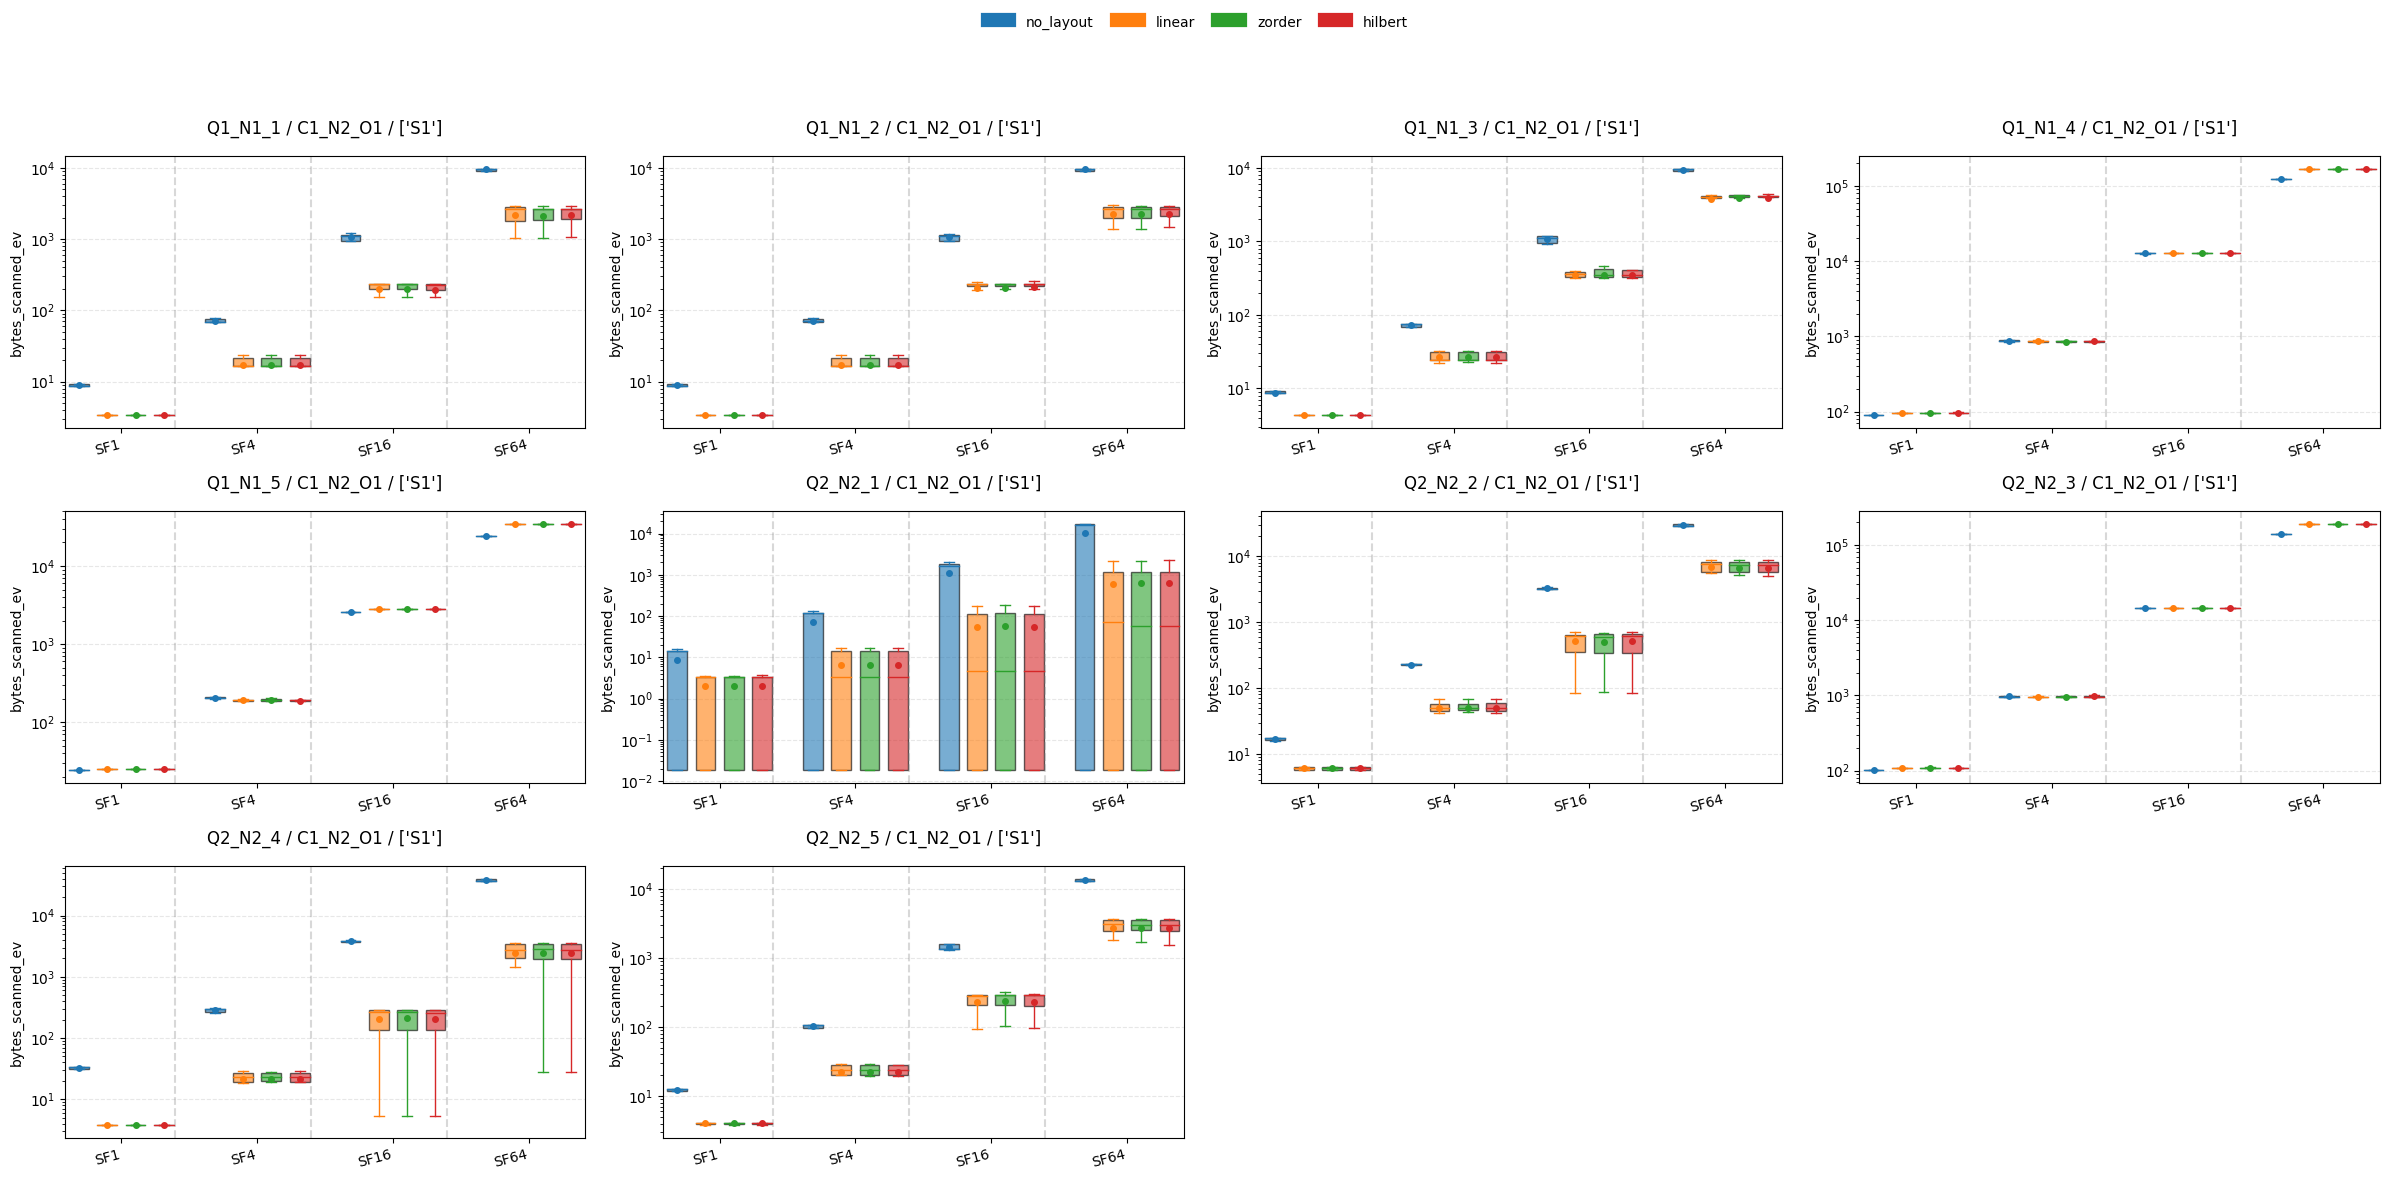

In [5]:
# Example usage: adjust queries/selectivity/metric per cell
fig, _ = plot_rq3_tpch_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3", "Q1_N1_4", "Q1_N1_5",
     "Q2_N2_1", "Q2_N2_2", "Q2_N2_3", "Q2_N2_4", "Q2_N2_5"],
    selectivity_filter=["S1"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq3_tpch_Q1_Q2_S1_bytes_scanned_ev",
)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_41250/3431289003.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.pdf


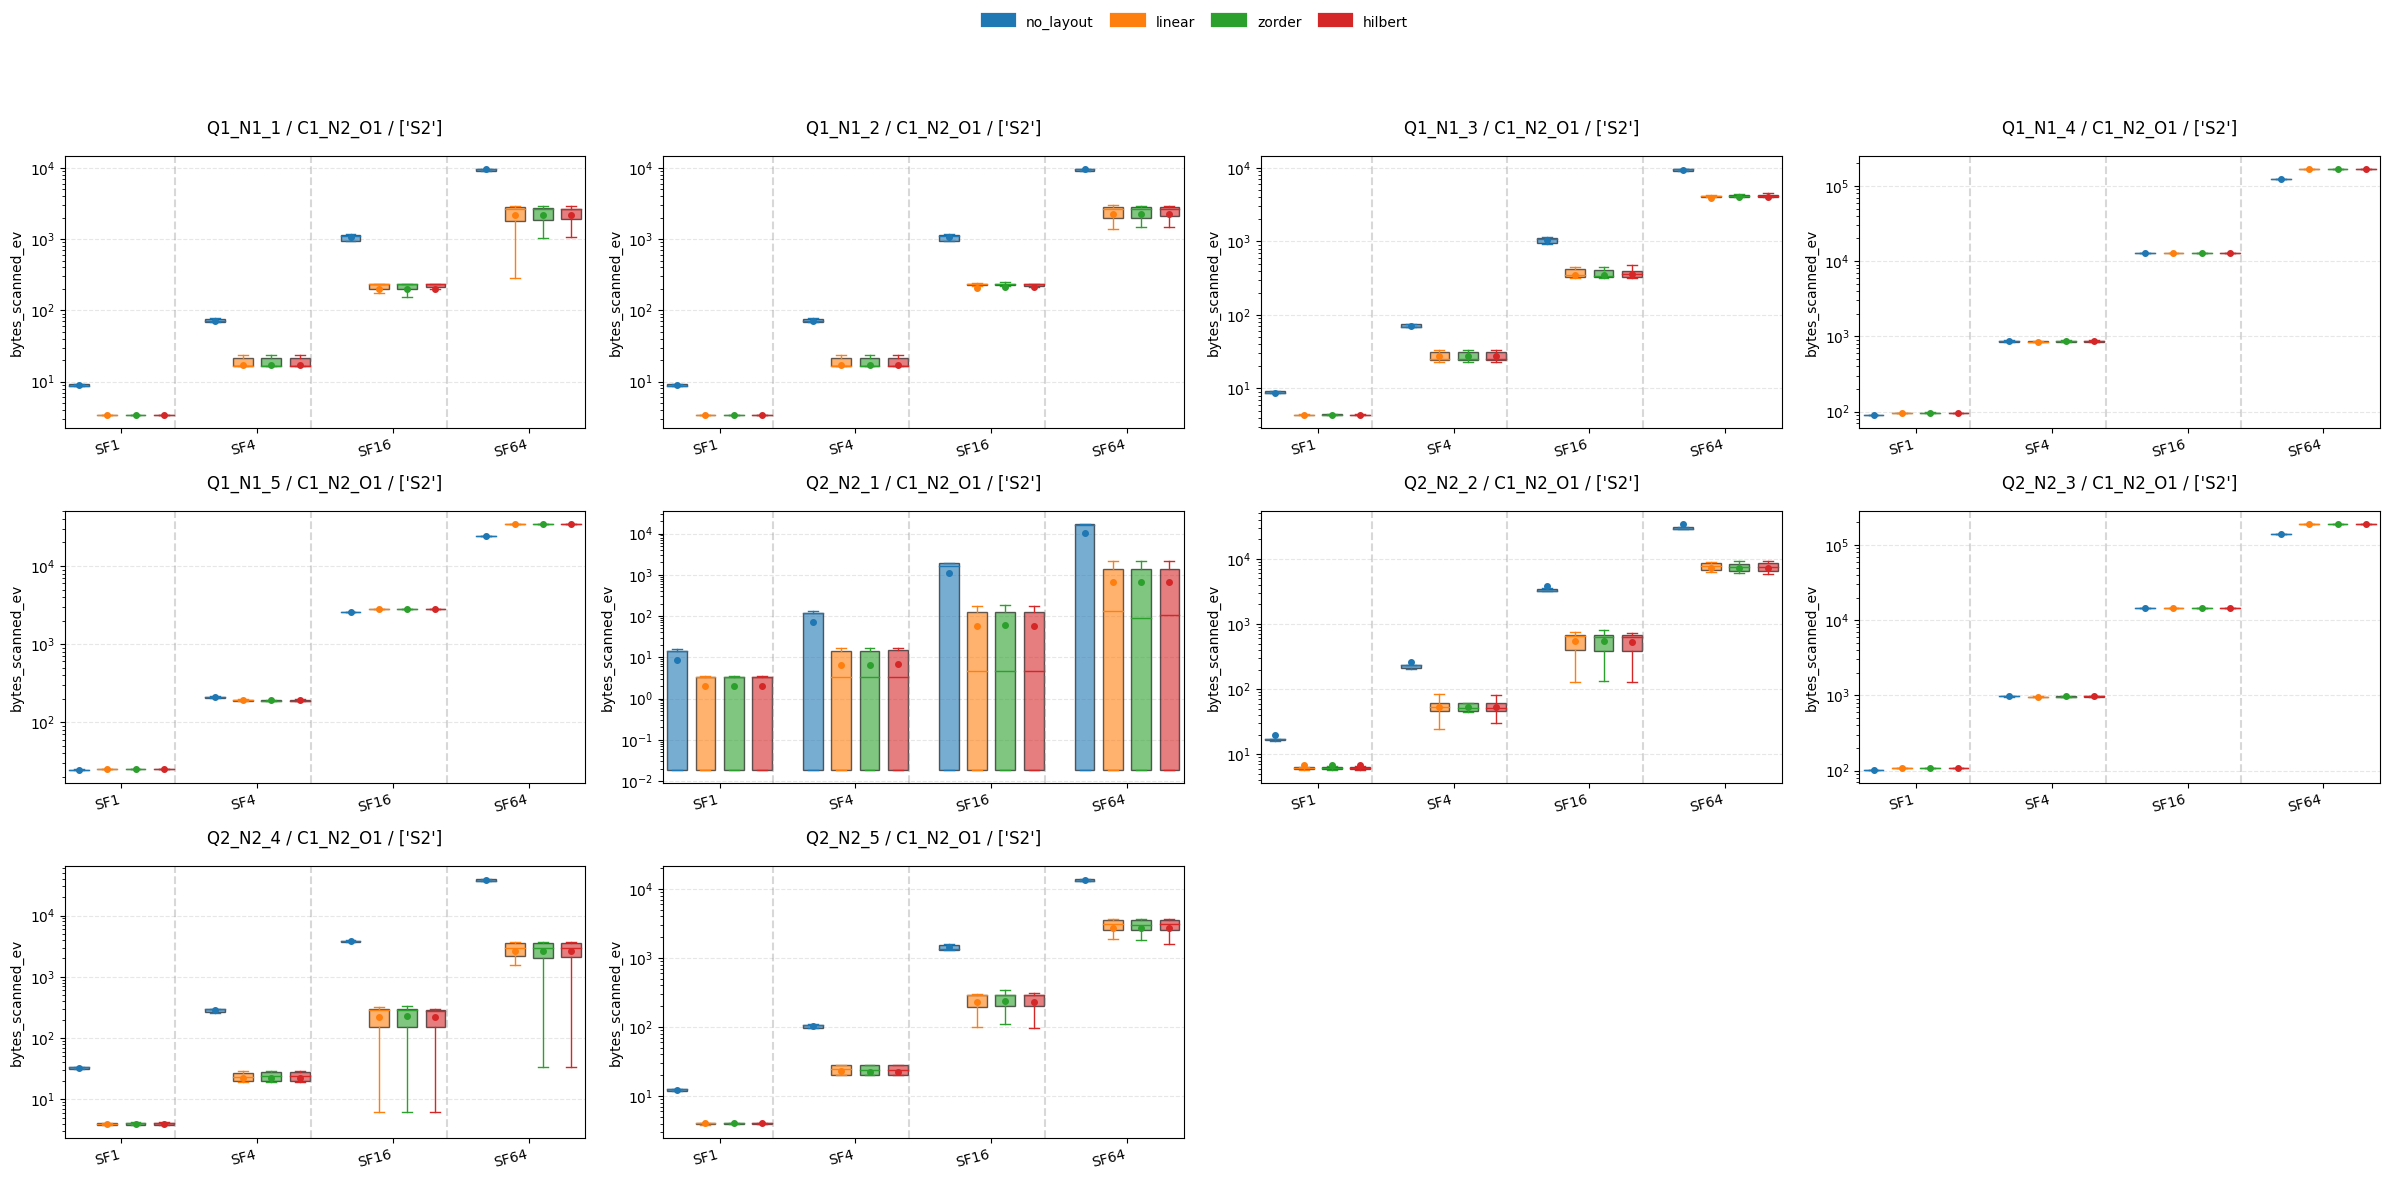

In [6]:
fig, _ = plot_rq3_tpch_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3", "Q1_N1_4", "Q1_N1_5",
     "Q2_N2_1", "Q2_N2_2", "Q2_N2_3", "Q2_N2_4", "Q2_N2_5"],
    selectivity_filter=["S2"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq3_tpch_Q1_Q2_S1_bytes_scanned_ev",
)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_41250/3431289003.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.pdf


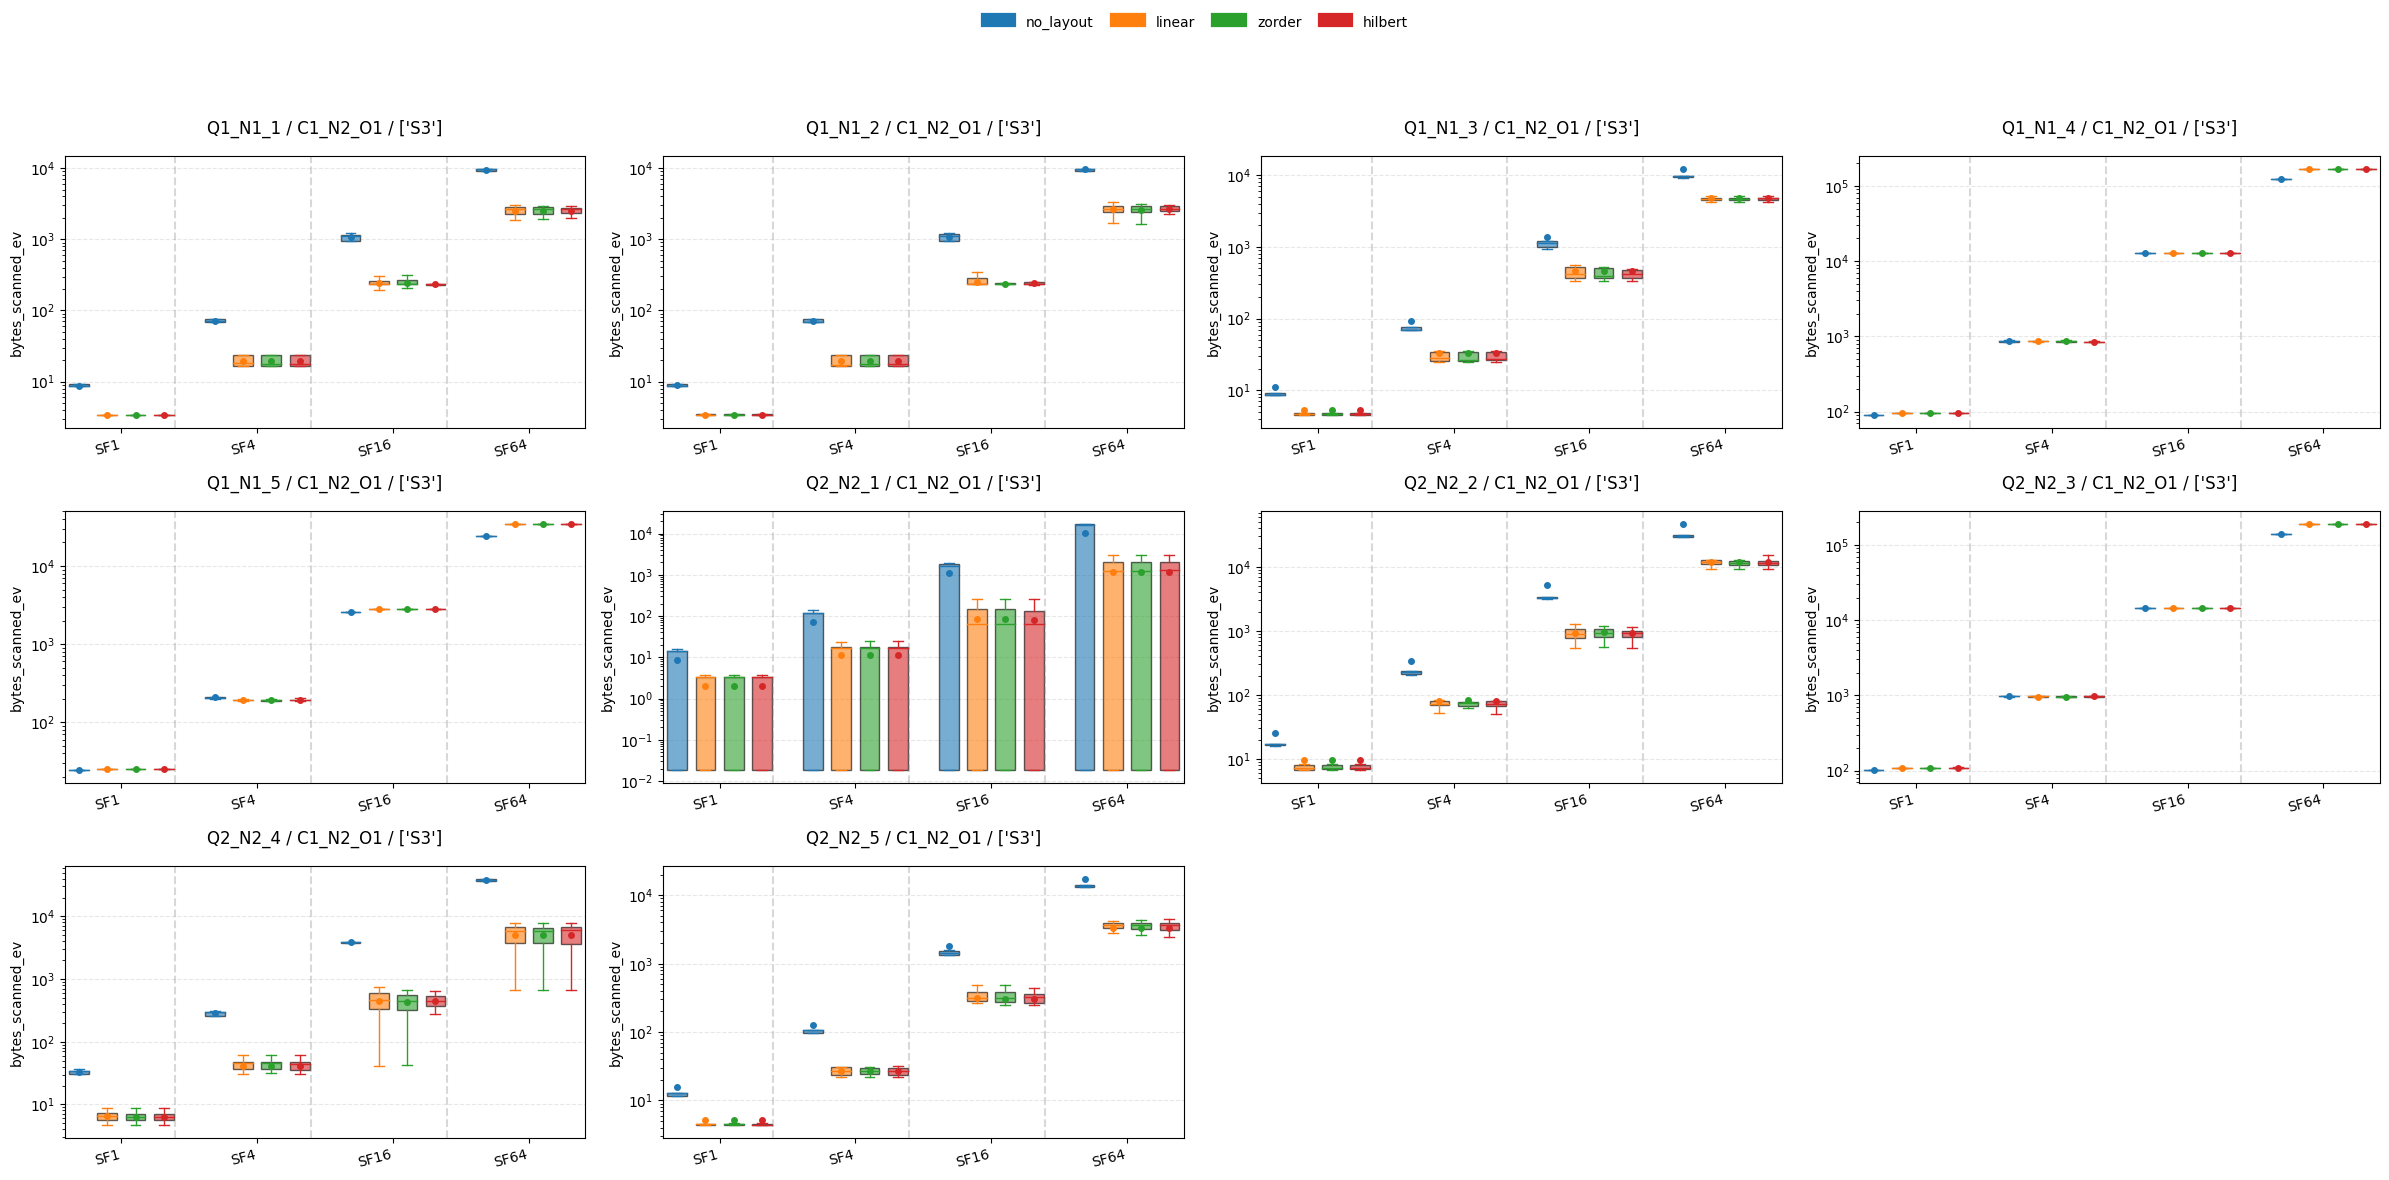

In [7]:
fig, _ = plot_rq3_tpch_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3", "Q1_N1_4", "Q1_N1_5",
     "Q2_N2_1", "Q2_N2_2", "Q2_N2_3", "Q2_N2_4", "Q2_N2_5"],
    selectivity_filter=["S3"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq3_tpch_Q1_Q2_S1_bytes_scanned_ev",
)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_41250/3431289003.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q1_Q2_S1_bytes_scanned_ev.pdf


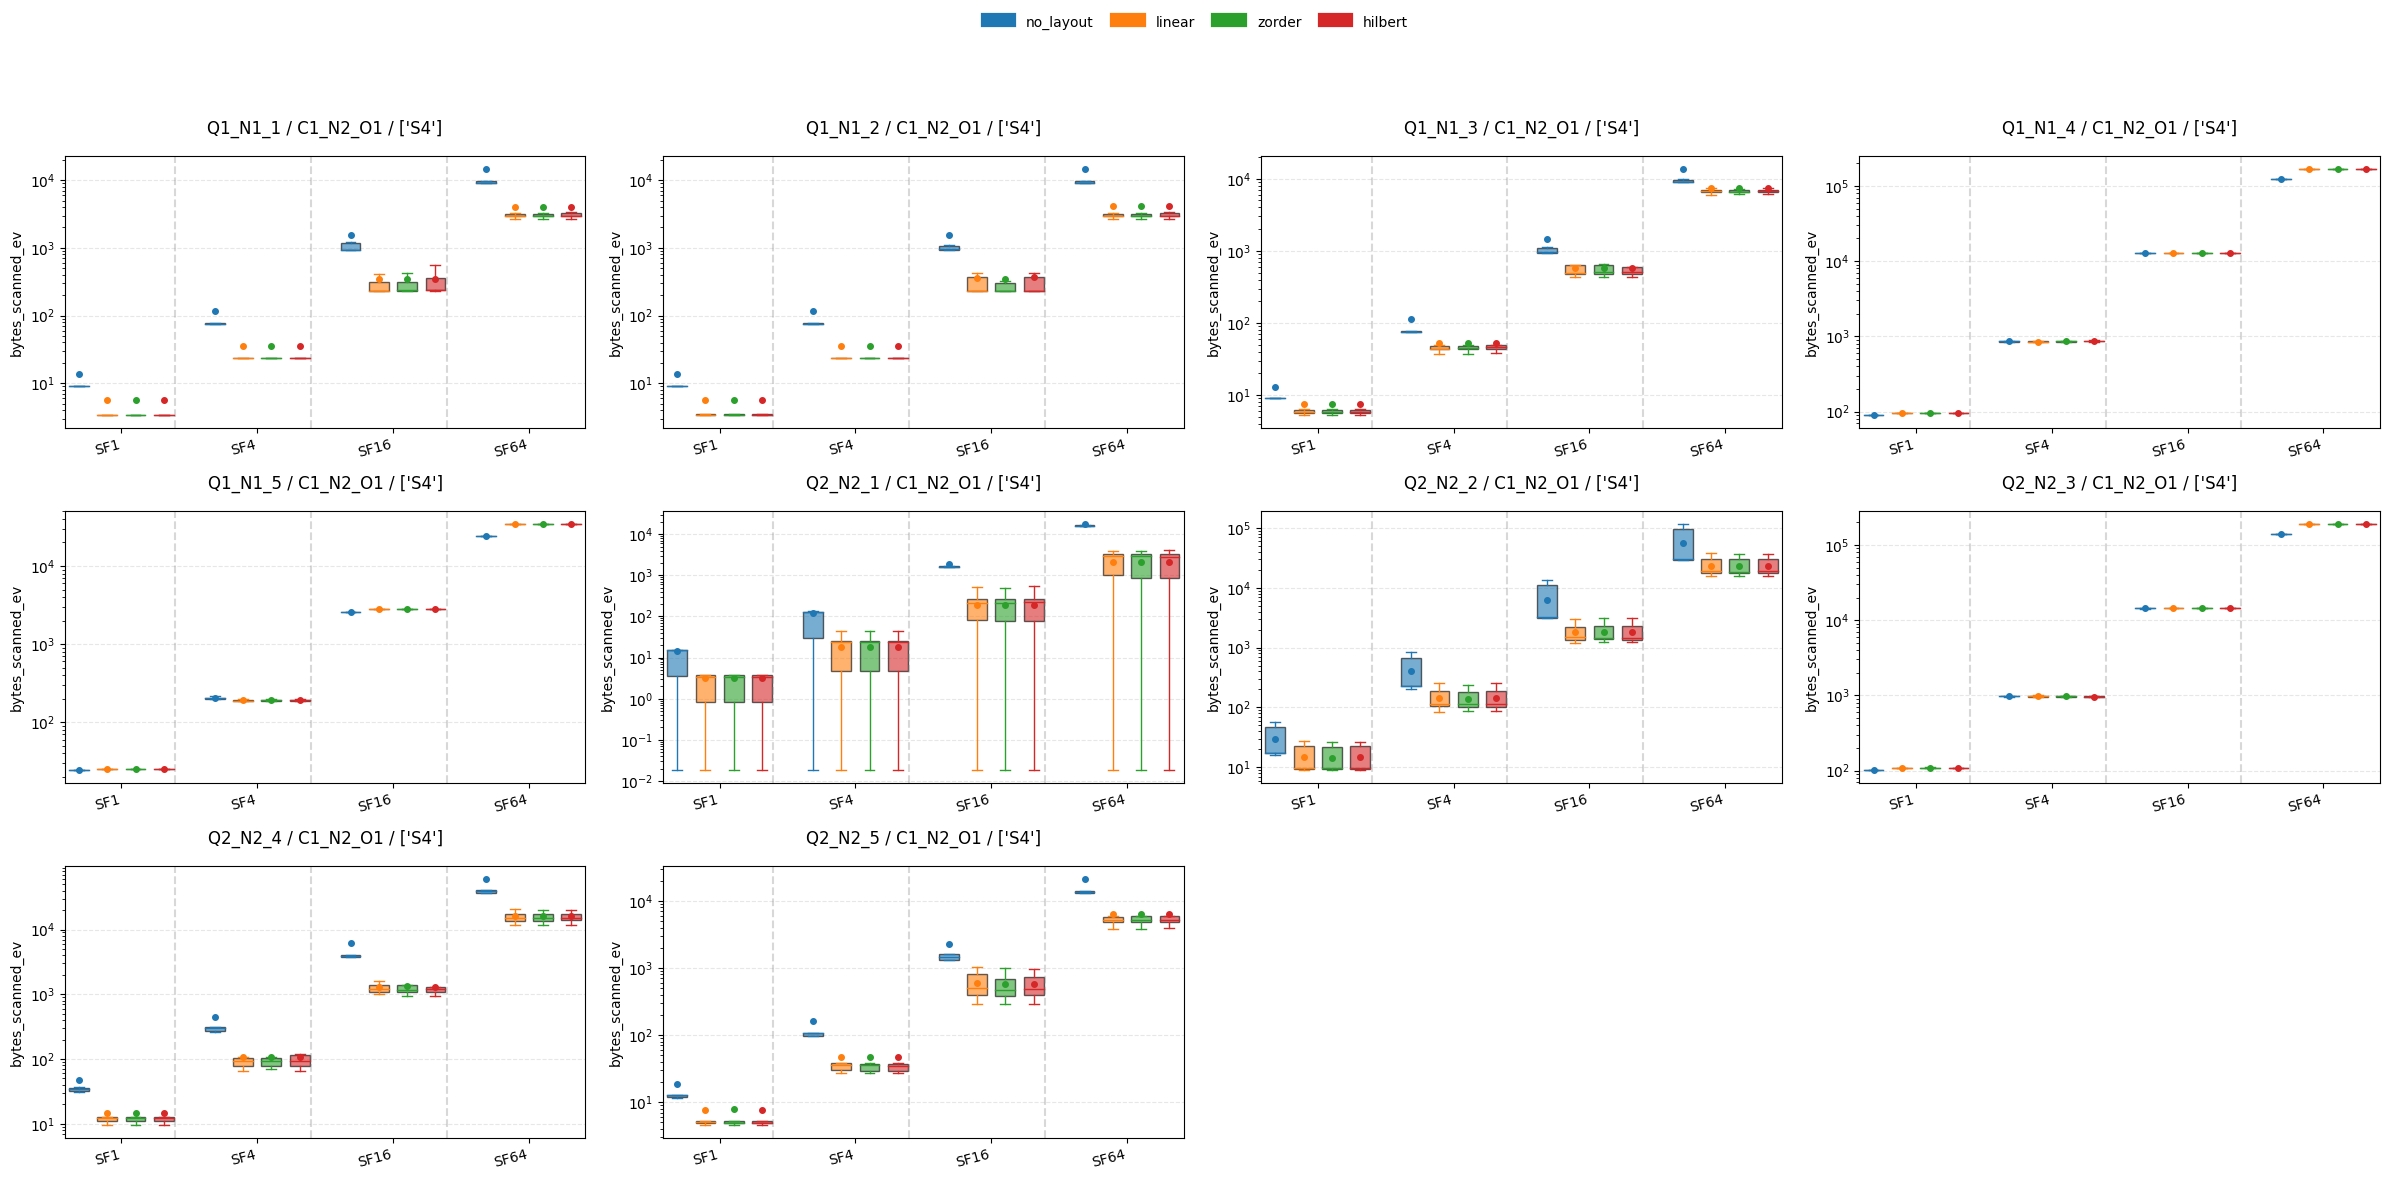

In [8]:
fig, _ = plot_rq3_tpch_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3", "Q1_N1_4", "Q1_N1_5",
     "Q2_N2_1", "Q2_N2_2", "Q2_N2_3", "Q2_N2_4", "Q2_N2_5"],
    selectivity_filter=["S4"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq3_tpch_Q1_Q2_S1_bytes_scanned_ev",
)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_41250/3431289003.py:176: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q3_S0_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq3_tpch_Q3_S0_bytes_scanned_ev.pdf


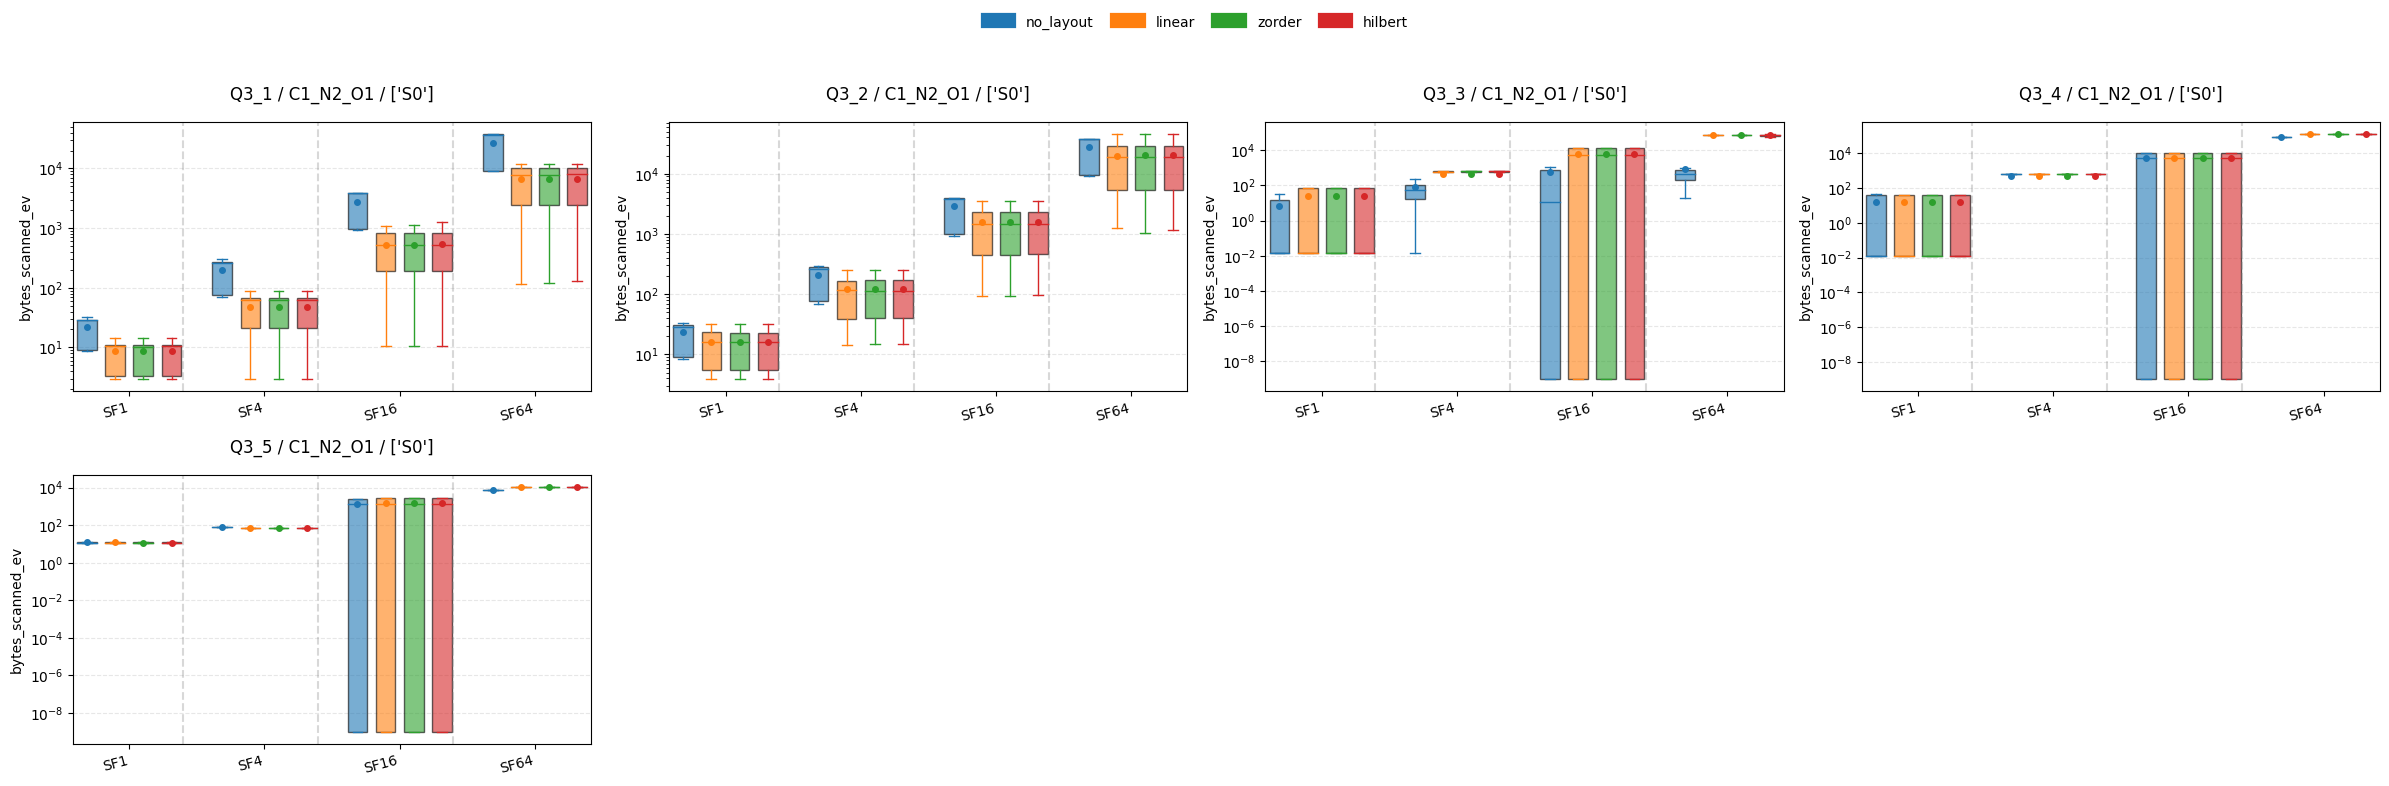

In [9]:
# --- Example: aggregate Q3 fan-outs into multiple aliases ---
RQ3_GROUPS = {
    f"Q3_{idx}": [f"Q3_K{k}_{idx}" for k in (1, 2, 4, 8, 16)]
    for idx in [1, 2, 3, 4, 5]
}

fig, _ = plot_rq3_tpch_query_groups(
    RQ3_GROUPS,
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq3_tpch_Q3_S0_bytes_scanned_ev",
)
